In [6]:
import os
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers



In [8]:
dataset_dir = r"C:\Users\Hanss\Documents\Utbildning\Deep Learning\Rock_Papper_Scissors_Projekt"

class_names = os.listdir(dataset_dir)
class_counts = {}

for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    num_samples = len(os.listdir(class_dir))
    class_counts[class_name] = num_samples

print("Class Counts:", class_counts)



Class Counts: {'paper': 712, 'rock': 726, 'scissors': 750}


In [9]:
total_samples = sum(class_counts.values())
num_classes = len(class_names)
class_weights = {}

for class_name, count in class_counts.items():
    class_index = class_names.index(class_name)
    class_weights[class_index] = total_samples / (num_classes * count)

class_weights[0] += 0.8

print("Class Weights:", class_weights)

Class Weights: {0: 1.8243445692883895, 1: 1.0045913682277319, 2: 0.9724444444444444}


In [ ]:
#-------

In [10]:
IMG_SIZE = (200, 300)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Create train, val and test set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,  
    subset="training",     
    seed = 42,              
    image_size=IMG_SIZE,   
    batch_size=BATCH_SIZE  
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,  
    subset = "validation",   
    seed = 42,              
    image_size=IMG_SIZE,   
    batch_size=BATCH_SIZE  
)


Found 2188 files belonging to 3 classes.
Using 1751 files for training.
Found 2188 files belonging to 3 classes.
Using 437 files for validation.


In [11]:
# The images in the dataset are 200 x 300. These need to be resized because the image size that MobileNetV2 
# has trained is 224 x 224.

def resize_and_pad_image(image, label):
    
    scale_factor = 224 / 300
    new_width = 224  
    new_height = int(200 * scale_factor)  

    image = tf.image.resize(image, [new_height, new_width])

    pad_height = (224 - new_height) // 2 
    pad_top = pad_height
    pad_bottom = 224 - new_height - pad_top
    image = tf.image.pad_to_bounding_box(image, pad_top, 0, 224, 224)

    return image, label

train_ds = train_ds.map(resize_and_pad_image)
val_ds = val_ds.map(resize_and_pad_image)


In [17]:

# Define the data augmentation pipeline: testing different ways to change/create data images through data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.8),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    #layers.RandomZoom(0.2),
    #layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])



In [18]:
# Load the pretrained MobileNetV2 model without the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

for layer in base_model.layers[-1:]:  # Unfreeze one layer to gain a little more complexity
    layer.trainable = True

# Building the model
model = Sequential([
    data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001) 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint("rock_paper_scissors_best_model.keras", save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=10, 
                    callbacks=[early_stopping]
                    )




Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.4924 - loss: 1.5516 - val_accuracy: 0.7826 - val_loss: 0.5965
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.7705 - loss: 0.6355 - val_accuracy: 0.8101 - val_loss: 0.5184
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.8231 - loss: 0.5533 - val_accuracy: 0.8490 - val_loss: 0.4074
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 481ms/step - accuracy: 0.8501 - loss: 0.4392 - val_accuracy: 0.9222 - val_loss: 0.2564
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.8642 - loss: 0.3576 - val_accuracy: 0.9268 - val_loss: 0.2320
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.8715 - loss: 0.3561 - val_accuracy: 0.9291 - val_loss: 0.2192
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.8892 - loss: 0.3037 - val_accuracy: 0.9130 - val_loss: 0.2600
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.8987 - loss: 0.2674 - val_accu

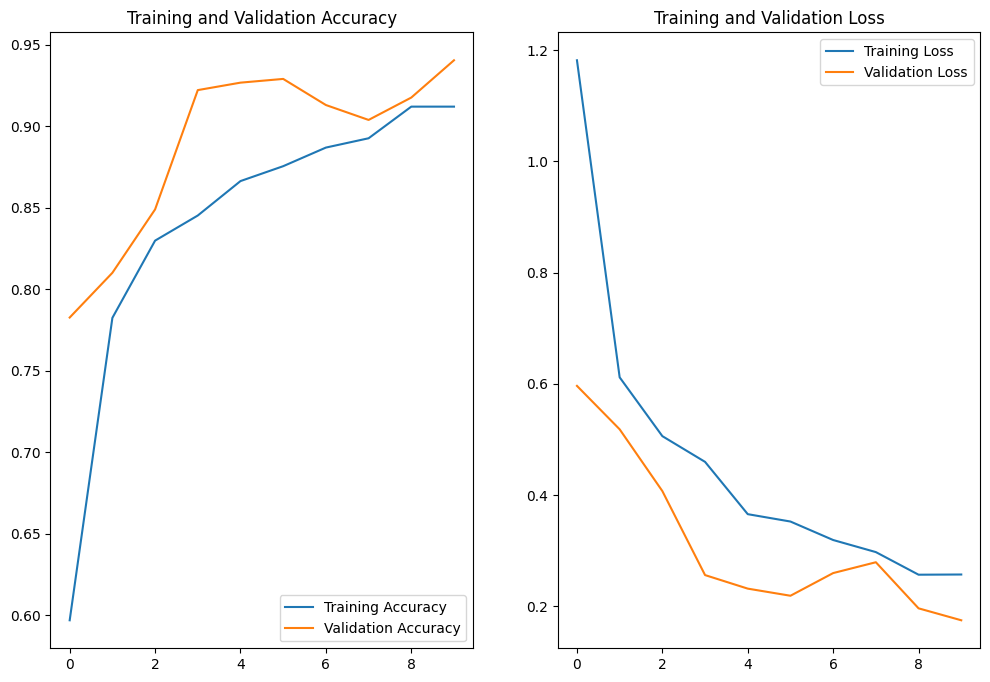

In [19]:
# looking at graphs of training and validation accuracy and loss across epochs. Visually 
# inspect the model's performance and check for signs of overfitting or underfitting.

def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_metrics(history)

In [20]:
# Load the pre-trained hand gesture model
classifier = load_model('rock_paper_scissors_best_model.keras')


gesture_labels = ['Rock', 'Paper', 'Scissors']

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, 
                       max_num_hands=2, 
                       min_detection_confidence=0.5, 
                       min_tracking_confidence=0.5
                       )

# Initialize video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

   # Convert the frame to RGB, as video capturing has format BGR
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # analyze hands on image
    results = hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get bounding box of the hand
            h, w, c = frame.shape
            bbox = []
            for landmark in hand_landmarks.landmark:
                bbox.append((int(landmark.x * w), int(landmark.y * h)))
            bbox = np.array(bbox)
            x_min, y_min = np.min(bbox, axis=0)
            x_max, y_max = np.max(bbox, axis=0)

            # Ensure the bounding box is within frame limits
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(w, x_max)
            y_max = min(h, y_max)

            # Extract hand region of interest (ROI) and preprocess it in the same way it was done for the model
            hand_roi = frame[y_min:y_max, x_min:x_max]
            if hand_roi.size > 0:
                hand_roi = cv2.resize(hand_roi, (200, 300))
                # Note: here the image should be padded when resizing to the size the model expects, but this step was skipped
                hand_roi = cv2.resize(hand_roi, (224, 224))
                hand_roi = cv2.cvtColor(hand_roi, cv2.COLOR_BGR2RGB)
                hand_roi = np.expand_dims(hand_roi, axis=0) / 255.0  # Normalize

                # Predict the hand gesture
                prediction = classifier.predict(hand_roi)[0]
                label = gesture_labels[np.argmax(prediction)]

                # Draw the bounding box and label on the frame
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(frame, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 255, 0), 2)

            # Draw the hand landmarks on the frame, interesting to see what mediapipe finds
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    cv2.imshow('Hand Gesture Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



c:\Users\Hanss\Documents\Utbildning\Deep Learning\VSUtbildning\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━